In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pytorch_lightning &> /dev/null

import torch
from torchvision import transforms
import torchvision
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.utils import draw_bounding_boxes
from PIL import ImageColor
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
from pytorch_lightning.loggers import tensorboard


use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [3]:
path = {}
path["images"] = "/content/drive/MyDrive/CIS 6800/SOLO dataset/hw3_mycocodata_img_comp_zlib.h5" 
path["labels"] = "/content/drive/MyDrive/CIS 6800/SOLO dataset/hw3_mycocodata_labels_comp_zlib.npy"
path["bboxes"] = "/content/drive/MyDrive/CIS 6800/SOLO dataset/hw3_mycocodata_bboxes_comp_zlib.npy"
path["masks"]  = "/content/drive/MyDrive/CIS 6800/SOLO dataset/hw3_mycocodata_mask_comp_zlib.h5"

In [140]:
import torch
from torchvision import transforms
import torchvision
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.utils import draw_bounding_boxes
from PIL import ImageColor
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
from torchvision.utils import draw_segmentation_masks


class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, path):
        #############################################
        # TODO Initialize  Dataset

        self.images = h5py.File(path["images"],'r')['data']
        self.masks = h5py.File(path["masks"],'r')['data']
        self.bboxes = np.load(path["bboxes"], allow_pickle=True)
        self.labels = np.load(path["labels"], allow_pickle=True)
        
        self.corresponding_masks = []
        # Aligning masks with labels
        count = 0
        for i, label in enumerate(self.labels):
            n = label.shape[0] 
            temp = []
            for j in range(n):
                temp.append(self.masks[count])
                count += 1
            self.corresponding_masks.append(temp)

        # Applying rescaling and mean, std, padding
        self.transform = torchvision.transforms.Compose([torchvision.transforms.Resize((800, 1066)), torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        self.resize = torchvision.transforms.Resize((800, 1066))
        self.pad = torch.nn.ZeroPad2d((11,11,0,0))

        #############################################


    # In this function for given index we rescale the image and the corresponding  masks, boxes
    # and we return them as output
    # output:
        # transed_img
        # label
        # transed_mask
        # transed_bbox
        # index
    def __getitem__(self, index):
        ################################
        # TODO return transformed images,labels,masks,boxes,index

        one_label = self.labels[index]
        one_image = self.images[index]
        one_bbox = self.bboxes[index]
        one_mask = self.corresponding_masks[index]

        one_label = torch.tensor(one_label)
        one_image, one_mask, one_bbox = self.pre_process_batch(one_image, one_mask, one_bbox)
        ################################

        assert one_image.shape == (3,800,1088)
        assert one_bbox.shape[0] == one_mask.shape[0]

        return one_image, one_label, one_mask, one_bbox, index
        

    # This function preprocess the given image, mask, box by rescaling them appropriately
    # output:
    #        img: (3,800,1088)
    #        mask: (n_box,800,1088)
    #        box: (n_box,4)
    def pre_process_batch(self, img, mask, box):
        #######################################
        # TODO apply the correct transformation to the images,masks,boxes

        img_normalized = img / 255.                     # Normalized between 0 & 1
        img_normalized = torch.tensor(img_normalized, dtype=torch.float)   # Converted to tensor
        img_scaled = self.transform(img_normalized)    # Rescaled to (800, 1066) and adjusted for given mean and std

        img_final = self.pad(img_scaled)              # Padded with zeros to get the shape as (800, 1088)

        msk_final = torch.zeros((len(mask), 800, 1088))           #Initializing mask tensor

        for i, msk in enumerate(mask):
            msk = msk/1.                                  # Converting it to uint8
            msk = torch.tensor(msk, dtype=torch.float).view(1,300,400)         # Converting it to tensor
            msk_scaled = self.pad(self.resize(msk).view(800,1066))            # Padding and resizing
            msk_scaled[msk_scaled < 0.5] = 0
            msk_scaled[msk_scaled > 0.5] = 1
            msk_final[i] = msk_scaled

        box = torch.tensor(box, dtype=torch.float)
        box_final = torch.zeros_like(box)
        box_final[:,1] = box[:,1] * 800/300                  # Scaling x
        box_final[:,3] = box[:,3] * 800/300                  # Scaling x
        box_final[:,0] = box[:,0] * (1066/400) + 11                # Scaling y
        box_final[:,2] = box[:,2] * (1066/400) + 11                # Scaling y
        
        return img_final, msk_final, box_final
        ######################################
    
    def __len__(self):
        return len(self.labels)


class BuildDataLoader(torch.utils.data.DataLoader):
    def __init__(self, dataset, batch_size, shuffle, num_workers):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_workers = num_workers


    # output:
    #  dict{images: (bz, 3, 800, 1088)
    #       labels: list:len(bz)
    #       masks: list:len(bz){(n_obj, 800,1088)}
    #       bbox: list:len(bz){(n_obj, 4)}
    #       index: list:len(bz)
    def collect_fn(self, batch):
        out_batch = {}
        out_batch["images"] = []
        out_batch["labels"] = []
        out_batch["masks"] = []
        out_batch["bboxes"] = []
        out_batch["index"] = []

        for i in batch:
            out_batch["images"].append(i[0])
            out_batch["labels"].append(i[1])
            out_batch["masks"].append(i[2])
            out_batch["bboxes"].append(i[3])
            out_batch["index"].append(i[4])

        out_batch["images"] = torch.stack(out_batch["images"], dim=0)
        return out_batch


    def loader(self):
        return DataLoader(self.dataset,
                          batch_size=self.batch_size,
                          shuffle=self.shuffle,
                          num_workers=self.num_workers,
                          collate_fn=self.collect_fn)




In [5]:
dataset = BuildDataset(path)
train_size = 2000
test_size = 400

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 4
train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
train_loader = train_build_loader.loader()
test_build_loader = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = test_build_loader.loader()

In [141]:
import numpy as np
import torch
from functools import partial
from torchvision import ops
from sklearn import metrics

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

def prec_rec(scores_each, gt_labels_each, tp_each):
  sorted_scores_idx = np.argsort(np.array(scores_each))
  sorted_tp = np.array(tp_each)[sorted_scores_idx][::-1]
  rec = []
  pre = []

  fp_tot = 0
  tp_tot = 0
  rec = []
  prec = []
  for i,one_val in enumerate(sorted_tp):
    if one_val == 0:
      fp_tot += 1
    elif one_val == 1:
      tp_tot += 1

    one_prec = tp_tot/(tp_tot+fp_tot)
    one_rec = tp_tot/len(gt_labels_each)
    rec.append(one_rec)
    prec.append(one_prec)
    if one_rec == 1:
      break

  return metrics.auc(rec,prec), rec, prec

def conv_box(box):
  fin_box = torch.zeros_like(box)
  fin_box[:,0] = box[:,0] - (box[:,2]/2)
  fin_box[:,1] = box[:,1] - (box[:,3]/2)
  fin_box[:,2] = box[:,0] + (box[:,2]/2)
  fin_box[:,3] = box[:,1] + (box[:,3]/2)
  return fin_box


def MultiApply(func, *args, **kwargs):
    pfunc = partial(func, **kwargs) if kwargs else func
    map_results = map(pfunc, *args)
    return tuple(map(list, zip(*map_results)))

# This function computes the IOU between two set of boxes
def IOU_gt(boxA, boxB):
    ##################################
    #TODO compute the IOU between the boxA, boxB boxes

    boxA_conv = torch.zeros_like(boxA)
    boxA_conv[:,0] = boxA[:,0] - (boxA[:,2]/2)
    boxA_conv[:,2] = boxA[:,0] + (boxA[:,2]/2)
    boxA_conv[:,1] = boxA[:,1] - (boxA[:,3]/2)
    boxA_conv[:,3] = boxA[:,1] + (boxA[:,3]/2)

    iou_torched = ops.box_iou(boxA_conv.to(device), boxB.to(device)) 
    ##################################
    return iou_torched



# This function flattens the output of the network and the corresponding anchors 
# in the sense that it concatenates  the outputs and the anchors from all the grid cells
# from all the images into 2D matrices
# Each row of the 2D matrices corresponds to a specific anchor/grid cell
# Input:
#       out_r: (bz,4,grid_size[0],grid_size[1])
#       out_c: (bz,1,grid_size[0],grid_size[1])
#       anchors: (grid_size[0],grid_size[1],4)
# Output:
#       flatten_regr: (bz*grid_size[0]*grid_size[1],4)
#       flatten_clas: (bz*grid_size[0]*grid_size[1])
#       flatten_anchors: (bz*grid_size[0]*grid_size[1],4)
def output_flattening(out_r,out_c,anchors):
    #######################################
    # TODO flatten the output tensors and anchors
    bz = out_r.shape[0]
    flatten_regr = out_r.permute(0,2,3,1).reshape(-1,4)
    flatten_clas = out_c.squeeze(1).reshape(-1)
    flatten_anchors = anchors.reshape(-1,4).repeat(1,bz)
    
    #######################################
    return flatten_regr, flatten_clas, flatten_anchors




# This function decodes the output that is given in the encoded format (defined in the handout)
# into box coordinates where it returns the upper left and lower right corner of the proposed box
# Input:
#       flatten_out: (total_number_of_anchors*bz,4)
#       flatten_anchors: (total_number_of_anchors*bz,4)
# Output:
#       box: (total_number_of_anchors*bz,4)
def output_decoding_postprocess(flatten_out,flatten_anchors, device=device):
    #######################################
    # TODO decode the output
    flatten_anchors = conv_box_to_xywh(flatten_anchors)
    conv_box = torch.zeros_like(flatten_anchors).to(device)
    
    conv_box[:,3] = torch.exp(flatten_out[:,3]) * flatten_anchors[:,3]
    conv_box[:,2] = torch.exp(flatten_out[:,2]) * flatten_anchors[:,2]
    conv_box[:,1] = (flatten_out[:,1] * flatten_anchors[:,2]) + flatten_anchors[:,1]
    conv_box[:,0] = (flatten_out[:,0] * flatten_anchors[:,3]) + flatten_anchors[:,0]

    box = conv_box_to_corners(conv_box)

    #######################################
    return box

# This function converts x,y,w,h to x1,y1,x2,y2
def conv_box_to_corners(box):
    fin_box = torch.zeros_like(box)
    fin_box[:,0] = box[:,0] - (box[:,2]/2)
    fin_box[:,1] = box[:,1] - (box[:,3]/2)
    fin_box[:,2] = box[:,0] + (box[:,2]/2)
    fin_box[:,3] = box[:,1] + (box[:,3]/2)
    return fin_box

# This function converts x1,y1,x2,y2 to x,y,w,h 
def conv_box_to_xywh(box):
    fin_box = torch.zeros_like(box)
    fin_box[:,0] = (box[:,0] + box[:,2]) / 2
    fin_box[:,1] = (box[:,1] + box[:,3]) / 2
    fin_box[:,2] = (box[:,2] - box[:,0])
    fin_box[:,3] = (box[:,3] - box[:,1])
    return fin_box


def pretrained_models_680(checkpoint_file,eval=True):
    import torchvision
    model_fpn = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)

    if(eval):
        model_fpn.eval()

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model_fpn.to(device)

    backbone = model_fpn.backbone
    rpn = model_fpn.rpn

    if(eval):
        backbone.eval()
        rpn.eval()

    rpn.nms_thresh=0.6
    checkpoint = torch.load(checkpoint_file, device)

    backbone.load_state_dict(checkpoint['backbone'])
    rpn.load_state_dict(checkpoint['rpn'])

    return backbone, rpn


def visualizer_top_proposals(image, boxes, labels):
    labels = np.array(labels)
    boxes = boxes.detach().cpu().numpy()

    image = image.detach().cpu().numpy()
    image = np.clip(image, 0., 255.)

    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot()

    ax.imshow(image)
    for i in range(len(boxes)):

      if labels[i] == 0 :
        rect = patches.Rectangle((boxes[i][0], boxes[i][1],), boxes[i][2] - boxes[i][0], boxes[i][3] - boxes[i][1] , fill=False,color='blue')
        ax.add_patch(rect)
      elif labels[i] == 1:
        rect = patches.Rectangle((boxes[i][0], boxes[i][1],), boxes[i][2] - boxes[i][0], boxes[i][3] - boxes[i][1] , fill=False,color='green')
        ax.add_patch(rect)
      elif labels[i] == 2:
        rect = patches.Rectangle((boxes[i][0], boxes[i][1],), boxes[i][2] - boxes[i][0], boxes[i][3] - boxes[i][1] , fill=False,color='red')
        ax.add_patch(rect)

def visualize_raw_processor(img, mask,label, alpha=0.5):
    processed_mask = mask.clone().detach().squeeze().bool()
    img = img.clone().detach()[:, :, 11:-11]

    inv_transform = torchvision.transforms.Compose([torchvision.transforms.Normalize(mean=[ 0., 0., 0. ], std=[1/0.229, 1/0.224, 1/0.255]), torchvision.transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.])])
    pad = torch.nn.ZeroPad2d((11,11,0,0))
    processed_img = pad(inv_transform(img))

    processed_img = processed_img.detach().cpu().numpy()

    processed_img = np.clip(processed_img, 0, 1)
    processed_img = torch.from_numpy((processed_img * 255.).astype(np.uint8))

    img_to_draw = processed_img.detach().clone()

    if processed_mask.ndim == 2:
        processed_mask = processed_mask[None, :, :]
    for mask, lab in zip(processed_mask, label):
        if lab.item() == 0 :            # vehicle
            colored = 'blue'
            color = torch.tensor(ImageColor.getrgb(colored), dtype=torch.uint8)
            img_to_draw[:, mask] = color[:, None]
        if lab.item() == 1 :            # person
            colored = 'green'
            color = torch.tensor(ImageColor.getrgb(colored), dtype=torch.uint8)
            img_to_draw[:, mask] = color[:, None]
        if lab.item() == 2 :            # animal
            colored = 'red'
            color = torch.tensor(ImageColor.getrgb(colored), dtype=torch.uint8)
            img_to_draw[:, mask] = color[:, None]
 
    out = (processed_img * (1 - alpha) + img_to_draw * alpha).to(torch.uint8)
    # out = draw_bounding_boxes(out, bbox, colors='red', width=2)
    final_img = out.numpy().transpose(1,2,0)
    plt.figure()
    plt.imshow(final_img)
    return final_img

# Box Head

In [28]:
import torch
import torch.nn.functional as F
from torch import nn, Tensor
import pytorch_lightning as pl
from torchvision.models.detection.image_list import ImageList
import random
from matplotlib import image
from numpy import dtype
from torchvision import transforms
import torchvision
from torch.optim.lr_scheduler import MultiStepLR


use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

class BoxHead(pl.LightningModule):
    _default_cfg = {
        'classes': 3,
        'P': 7
    }

    def __init__(self, **kwargs):
        super().__init__()
        for k, v in {**self._default_cfg, **kwargs}.items():
            setattr(self, k, v)

        self.C=self._default_cfg['classes']
        self.P=self._default_cfg['P']
        self.image_size = (800,1088)
        self.pretrained_path = '/content/drive/MyDrive/CIS 6800/SOLO dataset/checkpoint680.pth'
        with torch.no_grad():
          self.backbone, self.rpn = pretrained_models_680(self.pretrained_path)
        self.keep_topK = 200

        self.train_loss_epoch = []
        self.train_class_loss_epoch = []
        self.train_reg_loss_epoch = []

        self.val_loss_epoch = []
        self.val_class_loss_epoch = []
        self.val_reg_loss_epoch = []

        # TODO initialize BoxHead
        self.intermediate_layer = nn.Sequential(
            nn.Linear(in_features=256*self.P*self.P, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=1024),
            nn.ReLU()
        )

        self.classifier_head = nn.Sequential(
            nn.Linear(in_features=1024, out_features=self.C+1)
    
        )

        self.regressor_head = nn.Sequential(
            nn.Linear(in_features=1024, out_features=4*self.C)
        )
        
        self.mask_head = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=256, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=3, kernel_size=1, padding='same'),
            nn.Sigmoid()
        )
        
    def create_ground_truth(self,proposals,gt_labels,bbox):
          """     
          This function assigns to each proposal either a ground truth box or the background class (we assume background class is 0)
          Input:
            proposals: list:len(bz){(per_image_proposals,4)} ([x1,y1,x2,y2] format)
            gt_labels: list:len(bz) {(n_obj)}
            bbox: list:len(bz){(n_obj, 4)}
          Output: (make sure the ordering of the proposals are consistent with MultiScaleRoiAlign)
            labels: (total_proposals,1) (the class that the proposal is assigned)
            regressor_target: (total_proposals,4) (target encoded in the [t_x,t_y,t_w,t_h] format)
          """        
          all_labels = []
          all_regressor_targets = []
          for per_image_proposal, per_image_gt_label, per_image_bbox in zip(proposals, gt_labels, bbox):
              per_image_gt_label = per_image_gt_label.clone().detach().to(device).float()
              each_labels = (-1.)*torch.ones(per_image_proposal.shape[0]).float().to(device)
              each_regressor_target = torch.ones(per_image_proposal.shape[0], 4).to(device)
              per_image_bbox = per_image_bbox.to(device)
              per_image_proposal = per_image_proposal.to(device)
              iou = torchvision.ops.box_iou(per_image_proposal, per_image_bbox)
              per_image_proposal = conv_box_to_xywh(per_image_proposal)
              per_image_bbox = conv_box_to_xywh(per_image_bbox)

              max_iou, max_iou_idx = torch.max(iou, dim=1)
              max_iou_idx = max_iou_idx.long()
              above_thres = torch.where(max_iou > 0.4)

              if len(above_thres[0]) != 0. : 
                  each_labels[above_thres[0].long()] = torch.stack([per_image_gt_label[i] for i in max_iou_idx[above_thres[0].long()]])
                  # print("Inside loss iteration : ", torch.where(each_labels < 0.)[0].shape)
                  each_regressor_target[above_thres[0].long()] = torch.stack([per_image_bbox[i] for i in max_iou_idx[above_thres[0].long()]])

                  conv_each_regressor_target = torch.zeros_like(per_image_proposal)
                  conv_each_regressor_target[:,0] = (each_regressor_target[:,0] - per_image_proposal[:,0]) / per_image_proposal[:,2]
                  conv_each_regressor_target[:,1] = (each_regressor_target[:,1] - per_image_proposal[:,1]) / per_image_proposal[:,3]
                  conv_each_regressor_target[:,2] = torch.log(each_regressor_target[:,2]/per_image_proposal[:,2])
                  conv_each_regressor_target[:,3] = torch.log(each_regressor_target[:,3]/per_image_proposal[:,3])

                  all_labels.append(each_labels)
                  all_regressor_targets.append(conv_each_regressor_target)
              else : 
                  # print("Entering inside")
                  all_labels.append(each_labels)
                  all_regressor_targets.append(each_regressor_target)


          labels = torch.cat(all_labels, dim=0)
          background_mask = labels < 0.
          regressor_target = torch.cat(all_regressor_targets, dim=0)
          regressor_target[background_mask] = 0.
          return labels,regressor_target



    def MultiScaleRoiAlign_boxhead(self, fpn_feat_list,proposals,P=7):
        """    
        This function for each proposal finds the appropriate feature map to sample and using RoIAlign it samples
        a (256,P,P) feature map. This feature map is then flattened into a (256*P*P) vector
        Input:
            fpn_feat_list: list:len(FPN){(bz,256,H_feat,W_feat)}
            proposals: list:len(bz){(per_image_proposals,4)} ([x1,y1,x2,y2] format)
            P: scalar
        Output:
            feature_vectors: (total_proposals, 256*P*P)  (make sure the ordering of the proposals are the same as the ground truth creation)
        #####################################
        # Here you can use torchvision.ops.RoIAlign check the docs
        #####################################
        """
        roi_alls = []
        for i in range(len(proposals)):
            each_proposal= conv_box_to_xywh(proposals[i])
            k = (torch.log2(torch.sqrt(each_proposal[:,2]*each_proposal[:,3])/224.) + 4).int()
            k = torch.clamp(k, min=2., max=5.).int()
            each_proposal = conv_box_to_corners(each_proposal)

            scaling_vals = torch.pow(2,k).reshape(-1,1)*torch.ones_like(each_proposal)
            scaled_proposals = each_proposal / scaling_vals

            fpn_list_each_proposal = [fpn_feat_list[j][i].unsqueeze(0) for j in range(5)]
            roi_vals = torch.stack([torchvision.ops.roi_align(fpn_list_each_proposal[k[n]-2], [scaled_proposals[n].view(1,4)], (P,P)).squeeze(0) for n in range(k.shape[0])], dim=0).reshape(-1,256*P*P)
            roi_alls.append(roi_vals)
        feature_vectors = torch.cat(roi_alls, dim=0)

        return feature_vectors

    def MultiScaleRoiAlign_maskhead(self, fpn_feat_list,proposals,P=14):
        """    
        This function for each proposal finds the appropriate feature map to sample and using RoIAlign it samples
        a (256,P,P) feature map. This feature map is then flattened into a (256*P*P) vector
        Input:
            fpn_feat_list: list:len(FPN){(bz,256,H_feat,W_feat)}
            proposals: list:len(bz){(per_image_proposals,4)} ([x1,y1,x2,y2] format)
            P: scalar
        Output:
            feature_vectors: (total_proposals, 256,P,P)  (make sure the ordering of the proposals are the same as the ground truth creation)
        #####################################
        # Here you can use torchvision.ops.RoIAlign check the docs
        #####################################
        """
        roi_alls = []
        for i in range(len(proposals)):
            each_proposal= conv_box_to_xywh(proposals[i])
            k = (torch.log2(torch.sqrt(each_proposal[:,2]*each_proposal[:,3])/224.) + 4).int()
            k = torch.clamp(k, min=2., max=5.).int()
            each_proposal = conv_box_to_corners(each_proposal)

            scaling_vals = torch.pow(2,k).reshape(-1,1)*torch.ones_like(each_proposal)
            scaled_proposals = each_proposal / scaling_vals

            fpn_list_each_proposal = [fpn_feat_list[j][i].unsqueeze(0) for j in range(5)]
            roi_vals = torch.stack([torchvision.ops.roi_align(fpn_list_each_proposal[k[n]-2], [scaled_proposals[n].view(1,4)], (P,P)).squeeze(0) for n in range(k.shape[0])], dim=0)
            roi_alls.append(roi_vals)
        feature_vectors = torch.cat(roi_alls, dim=0)
        return feature_vectors



    def greedy_nms(self,clases,boxes,scores, IOU_thres=0.5, keep_num_postNMS=100):
        # Input:
        #       clases: (num_preNMS, )
        #       boxes:  (num_preNMS, 4)
        #       scores: (num_preNMS,)
        # Output:
        #       boxes:  (post_NMS_boxes_per_image,4) ([x1,y1,x2,y2] format)
        #       scores: (post_NMS_boxes_per_image)   ( the score for the top class for the regressed box)
        #       labels: (post_NMS_boxes_per_image)  (top category of each regressed box)
        ###########################################################

        scores_all = [[],[],[]]
        boxes_all = [[],[],[]]
        clas_all = [[],[],[]]

        for i in range(3):
            each_label_idx = torch.where(clases == i)[0]
            if len(each_label_idx) == 0:
              continue
            each_clas_boxes = boxes[each_label_idx]
            each_clas_score = scores[each_label_idx]

            start_x_torched = each_clas_boxes[:, 0]
            start_y_torched = each_clas_boxes[:, 1]
            end_x_torched   = each_clas_boxes[:, 2]
            end_y_torched   = each_clas_boxes[:, 3]

            areas_torched = (end_x_torched - start_x_torched + 1) * (end_y_torched - start_y_torched + 1)

            order_torched = torch.argsort(each_clas_score)

            while len(order_torched) > 0:
                # The index of largest confidence score
                index = order_torched[-1]
                
                # Pick the bounding box with largest confidence score
                boxes_all[i].append(boxes[index].detach())
                scores_all[i].append(each_clas_score[index].detach())

                if len(boxes_all[i]) == keep_num_postNMS:
                    break

                # Compute ordinates of intersection-over-union(IOU)
                x1 = torch.maximum(start_x_torched[index], start_x_torched[order_torched[:-1]])
                x2 = torch.minimum(end_x_torched[index], end_x_torched[order_torched[:-1]])
                y1 = torch.maximum(start_y_torched[index], start_y_torched[order_torched[:-1]])
                y2 = torch.minimum(end_y_torched[index], end_y_torched[order_torched[:-1]])

                # Compute areas of intersection-over-union
                w = torch.maximum(torch.tensor([0]), x2 - x1 + 1)
                h = torch.maximum(torch.tensor([0]), y2 - y1 + 1)
                intersection = w * h

                # Compute the ratio between intersection and union
                ratio = intersection / (areas_torched[index] + areas_torched[order_torched[:-1]] - intersection)
                left = torch.where(ratio < IOU_thres)[0]
                order_torched = order_torched[left]
            clas_all[i] = [i]*len(scores_all[i])
            
        fin_scores = torch.cat([torch.tensor(one_score).reshape(-1,1) for one_score in scores_all if len(one_score)!=0],dim=0).reshape(-1,1)
        fin_boxes = torch.cat([torch.stack(one_box) for one_box in boxes_all if len(one_box)!=0]).reshape(-1,4)
        fin_clas = torch.cat([torch.tensor(one_clas) for one_clas in clas_all if len(one_clas)!=0]).reshape(-1,1)
        return fin_clas, fin_scores, fin_boxes



    def postprocess_detections(self, class_logits, box_regression, proposals, conf_thresh=0.5, keep_num_preNMS=500, keep_num_postNMS=20):
        # This function does the post processing for the results of the Box Head for a batch of images
        # Use the proposals to distinguish the outputs from each image
        # Input:
        #       class_logits: (total_proposals,(C+1))
        #       box_regression: (total_proposal,4*C)           ([t_x,t_y,t_w,t_h] format)
        #       proposals: list:len(bz)(per_image_proposals,4) (the proposals are produced from RPN [x1,y1,x2,y2] format)
        #       conf_thresh: scalar
        #       keep_num_preNMS: scalar (number of boxes to keep pre NMS)
        #       keep_num_postNMS: scalar (number of boxes to keep post NMS)
        # Output:
        #       boxes: list:len(bz){(post_NMS_boxes_per_image,4)}  ([x1,y1,x2,y2] format)
        #       scores: list:len(bz){(post_NMS_boxes_per_image)}   ( the score for the top class for the regressed box)
        #       labels: list:len(bz){(post_NMS_boxes_per_image)}   (top class of each regressed box)
        
        class_logits = class_logits.cpu()
        box_regression = box_regression.cpu()
        num_proposals = proposals[0].shape[0]
        boxes = []
        scores = []
        labels = []
        for i, each_proposal in enumerate(proposals):
            each_proposal = each_proposal.cpu()
            one_image_boxes = box_regression[i*num_proposals:(i+1)*num_proposals]          # Shape (num_proposals, 12)
            one_image_logits = class_logits[i*num_proposals:(i+1)*num_proposals]           # Shape (num_proposals, 4)
            one_image_scores, one_image_label = torch.max(one_image_logits, dim=1)
            one_image_label = one_image_label.clone().int() - 1
            non_bg_label_idx = torch.where(one_image_label >= 0)[0].cpu()

          
            if len(non_bg_label_idx) != 0: 
                class_labels = one_image_label[non_bg_label_idx]
                all_class_boxes = one_image_boxes[non_bg_label_idx]
                class_boxes =  torch.stack([all_class_boxes[i, x*4:(x+1)*4] for i, x in enumerate(class_labels)])      # Shape(filtered_labels, 4) ([t_x,t_y,t_w,t_h])
                
                decoded_boxes = output_decoding_postprocess(class_boxes, each_proposal[non_bg_label_idx])                          # (x1,y1,x2,y2)
                decoded_boxes = decoded_boxes.cpu()

                valid_boxes_idx = torch.where((decoded_boxes[:,0] >= 0) & (decoded_boxes[:,2] < 1088) & (decoded_boxes[:,1] > 0) & (decoded_boxes[:,3] < 800))

                valid_boxes = decoded_boxes[valid_boxes_idx]
                valid_clases = one_image_label[non_bg_label_idx][valid_boxes_idx]
                valid_scores = one_image_scores[non_bg_label_idx][valid_boxes_idx]
                sorted_scores_pre_nms, sorted_idx = torch.sort(valid_scores, descending=True)
                sorted_clases_pre_nms = valid_clases[sorted_idx]
                sorted_boxes_pre_nms = valid_boxes[sorted_idx]
                
                if len(sorted_clases_pre_nms) > keep_num_preNMS:
                    clases_pre_nms = sorted_clases_pre_nms[:keep_num_preNMS]
                    boxes_pre_nms = sorted_boxes_pre_nms[:keep_num_preNMS]
                    scores_pre_nms = sorted_scores_pre_nms[:keep_num_preNMS]
                else:
                    clases_pre_nms = sorted_clases_pre_nms
                    boxes_pre_nms = sorted_boxes_pre_nms
                    scores_pre_nms = sorted_scores_pre_nms
                clases_post_nms, scores_post_nms, boxes_post_nms = self.greedy_nms(clases_pre_nms, boxes_pre_nms, scores_pre_nms, IOU_thres=conf_thresh, keep_num_postNMS=keep_num_postNMS)
            boxes.append(boxes_post_nms)
            scores.append(scores_post_nms)
            labels.append(clases_post_nms)

        return boxes, scores, labels


    def training_step(self, batch, batch_idx):
        images=batch['images'].to(device)
        index=batch['index']
        bounding_boxes=batch['bboxes']
        gt_label = batch['labels']

        self.backbone.eval()
        self.rpn.eval()
        with torch.no_grad():
          backout = self.backbone(images)
          im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
          rpnout = self.rpn(im_lis, backout)
        proposals=[proposal[0:self.keep_topK,:] for proposal in rpnout[0]]
        fpn_feat_list = list(backout.values())
        feature_vectors = self.MultiScaleRoiAlign_boxhead(fpn_feat_list,proposals)
        lbls, rgrssor_targ = self.create_ground_truth(proposals, gt_label, bounding_boxes)
            
        class_logits, box_pred = self.forward(feature_vectors)

        loss, loss_class, loss_regr = self.compute_loss(class_logits.to(device), box_pred.to(device), lbls.to(device), rgrssor_targ.to(device), l=0.2, effective_batch=100)
    
        del lbls, bounding_boxes, index, gt_label
        del rgrssor_targ
        torch.cuda.empty_cache()

        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        self.log("loss_class", loss_class, prog_bar=True)
        self.log("loss_regr", loss_regr, prog_bar=True)

        return {"loss":loss, "classifier_loss":loss_class, "regressor_loss":loss_regr}

    def training_epoch_end(self, training_step_outputs):
        avg_train_loss = 0
        avg_class_loss = 0
        avg_reg_loss = 0
        for i in range(len(training_step_outputs)):
            avg_train_loss += training_step_outputs[i]["loss"].detach().cpu().item()
            avg_class_loss += training_step_outputs[i]["classifier_loss"].detach().cpu().item()
            avg_reg_loss += training_step_outputs[i]["regressor_loss"]

        self.train_loss_epoch.append(avg_train_loss)
        self.train_class_loss_epoch.append(avg_class_loss)
        self.train_reg_loss_epoch.append(avg_reg_loss)


    def validation_step(self, batch, batch_idx):
        images=batch['images']
        index=batch['index']
        bounding_boxes=batch['bboxes']
        gt_label = batch['labels']

        self.backbone.eval()
        self.rpn.eval()
        with torch.no_grad():
          backout = self.backbone(images)
          im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
          rpnout = self.rpn(im_lis, backout)
        proposals=[proposal[0:self.keep_topK,:] for proposal in rpnout[0]]
        fpn_feat_list = list(backout.values())
        feature_vectors = self.MultiScaleRoiAlign_boxhead(fpn_feat_list,proposals)
        lbls, rgrssor_targ = self.create_ground_truth(proposals, gt_label, bounding_boxes)
            
        class_logits, box_pred = self.forward(feature_vectors)

        val_loss, loss_class, loss_regr = self.compute_loss(class_logits.to(device), box_pred.to(device), lbls.to(device), rgrssor_targ.to(device), l=0.2, effective_batch=100)

        del lbls, bounding_boxes, index, gt_label
        del rgrssor_targ
        torch.cuda.empty_cache()

        self.log("val_loss", val_loss)
        return {"loss":val_loss, "classifier_loss":loss_class, "regressor_loss":loss_regr}

    def validation_epoch_end(self, outputs):
        avg_train_loss = 0
        avg_class_loss = 0
        avg_reg_loss = 0
        for i in range(len(outputs)):
            avg_train_loss += outputs[i]["loss"].detach().cpu().item()
            avg_class_loss += outputs[i]["classifier_loss"].detach().cpu().item()
            avg_reg_loss += outputs[i]["regressor_loss"]
        
        self.val_loss_epoch.append(avg_train_loss)
        self.val_class_loss_epoch.append(avg_class_loss)
        self.val_reg_loss_epoch.append(avg_reg_loss)


    def configure_optimizers(self):

        optimizer = torch.optim.SGD(self.parameters(),lr = 0.0005,weight_decay=1.0e-4,momentum=0.90)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[22,28,35], gamma=0.1)

        return optimizer 


        #################################################
   # Compute the total loss of the classifier and the regressor
    # Input:
    #      class_logits: (total_proposals,(C+1)) (as outputed from forward, not passed from softmax so we can use CrossEntropyLoss)
    #      box_preds: (total_proposals,4*C)      (as outputed from forward)
    #      labels: (total_proposals,1)
    #      regression_targets: (total_proposals,4)
    #      l: scalar (weighting of the two losses)
    #      effective_batch: scalar
    # Outpus:
    #      loss: scalar
    #      loss_class: scalar
    #      loss_regr: scalar
    def compute_loss(self,class_logits, box_preds, labels, regression_targets,l=0.2,effective_batch=70):
        labels_all = labels.flatten()
        # print("labels all : ", labels_all)
        neg_mask = labels_all < 0.
        pos_mask = labels_all >= 0.
        labels_all = torch.where(labels_all < 0., 0., labels_all)

        num_neg_ind = neg_mask.sum().item()
        num_pos_ind = labels_all.shape[0] - num_neg_ind
        # print("Num neg ind : ", num_neg_ind)
        # print("Num pos ind : ", num_pos_ind)

        if num_pos_ind > (3*effective_batch/4):
            rand_pos_idx = torch.randperm(num_pos_ind)[:int(3*effective_batch/4)]
            rand_neg_idx = torch.randperm(num_neg_ind)[:int(effective_batch/4)]
            pos_clas_tar = labels_all[pos_mask][rand_pos_idx]
            neg_clas_tar = labels_all[neg_mask][rand_neg_idx]
            pos_clas_pred = class_logits[pos_mask][rand_pos_idx]
            neg_clas_pred = class_logits[neg_mask][rand_neg_idx]
            pos_box_pred = box_preds[pos_mask][rand_pos_idx]
            pos_box_tar = regression_targets[pos_mask][rand_pos_idx]
        else:
            rand_neg_idx = torch.randperm(num_neg_ind)
            pos_clas_tar = labels_all[pos_mask]
            neg_clas_tar = labels_all[neg_mask][rand_neg_idx][:(effective_batch - num_pos_ind)]
            pos_clas_pred = class_logits[pos_mask]
            neg_clas_pred = class_logits[neg_mask][rand_neg_idx][:(effective_batch - num_pos_ind)]
            pos_box_pred = box_preds[pos_mask]
            pos_box_tar = regression_targets[pos_mask]


        clas_preds = torch.vstack((pos_clas_pred,neg_clas_pred)).float()
        clas_tar   = torch.cat((pos_clas_tar,neg_clas_tar)).reshape(-1).long()
        one_hot_clas_tar = torch.nn.functional.one_hot(clas_tar, num_classes=4).float()

        clas_criterion = torch.nn.CrossEntropyLoss()
        clas_loss = clas_criterion(clas_preds, one_hot_clas_tar)

        class_labels_cor = (pos_clas_tar.clone() - 1).int()
        if num_pos_ind == 0:
          loss_regr = 0.
        else:
          box_regression_preds = torch.stack([one_box_regression[4*(class_labels_cor[i]):4*class_labels_cor[i]+4] for i, one_box_regression in enumerate(pos_box_pred)])
          reg_criterion = torch.nn.SmoothL1Loss(reduction = 'sum')
          loss_regr = reg_criterion(box_regression_preds,pos_box_tar) 

        loss = clas_loss + l*loss_regr 

        return loss, clas_loss, loss_regr
        ###################################################



    def forward(self, feature_vectors, eval=False):
        """
        Forward the pooled feature vectors through the intermediate layer and the classifier, regressor of the box head
        Input:
              feature_vectors: (total_proposals, 256*P*P)
        Outputs:
              class_logits: (total_proposals,(C+1)) (we assume classes are C classes plus background, 
                            notice if you want to use CrossEntropyLoss you should not pass the output through softmax here)
              box_pred:     (total_proposals,4*C)
        """

        #TODO forward through the Intermediate layer
        X = self.intermediate_layer(feature_vectors)

        #TODO forward through the Classifier Head
        class_logits = self.classifier_head(X)

        if eval==True:
          softmax = torch.nn.Softmax(dim = 1)
          class_logits = softmax(class_logits)

        #TODO forward through the Regressor Head
        box_pred = self.regressor_head(X)

        return class_logits, box_pred
    

# Train BoxHead

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
val_checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="./training_data_new_model_1",
    filename="val_loss{epoch:02d}-{val_loss:.2f}",
    save_top_k=3,
    mode="min",
)
train_checkpoint_callback = ModelCheckpoint(
    monitor="train_loss",
    dirpath="./training_data_new_model_1",
    filename="train_loss{epoch:02d}-{train_loss:.2f}",
    save_top_k=3,
    mode="min",
)

model_bh = BoxHead()

epochs = 45

tb_logger = pl_loggers.TensorBoardLogger("tb_logs", name="faster_rcnn")
# trainer = pl.Trainer(accelerator='cpu', devices=1, max_epochs=epochs, logger=tb_logger, callbacks=[val_checkpoint_callback,train_checkpoint_callback])
trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs=epochs, logger=tb_logger, callbacks=[val_checkpoint_callback,train_checkpoint_callback])
# trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs=epochs, logger=tb_logger, resume_from_checkpoint = "/content/training_data_new_model_1/train_lossepoch=27-train_loss=0.25.ckpt", callbacks=[val_checkpoint_callback,train_checkpoint_callback])

trainer.fit(model_bh, train_loader, test_loader)

PATH = 'model_trained_boxhead_2.pth'
torch.save(model_bh.state_dict(), PATH)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type                  | Params
-------------------------------------------------------------
0 | backbone           | BackboneWithFPN       | 26.8 M
1 | rpn                | RegionProposalNetwork | 593 K 
2 | intermediate_layer | Sequential            | 13.9 M
3 | classifier_head    | Sequential            | 4.1 K 
4 | regressor_head     | Sequential            | 12.3 K
5 | mask_head          | Sequential            | 2.4 M 
-------------------------------------------------------------
43.5 M    Trainable params
22

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/data.py:85: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1595: PossibleUserWarning: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=45` reached.


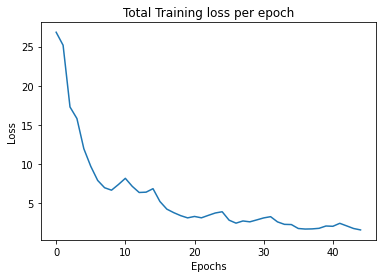

In [ ]:
tot_train_losses = model_bh.train_loss_epoch
plt.plot(tot_train_losses)
plt.title("Total Training loss per epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

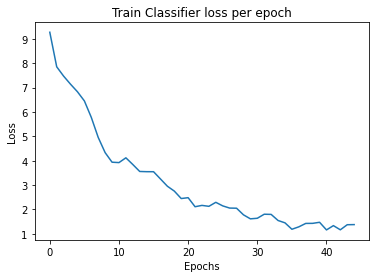

In [ ]:
tot_losses = model_bh.train_class_loss_epoch
plt.plot(tot_losses)
plt.title("Train Classifier loss per epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

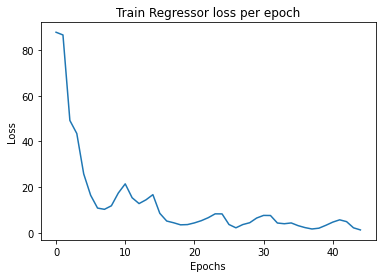

In [ ]:
tot_losses = model_bh.train_reg_loss_epoch
tot_losses = np.array([each_loss.detach().cpu().numpy() for each_loss in tot_losses])
plt.plot(tot_losses)
plt.title("Train Regressor loss per epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

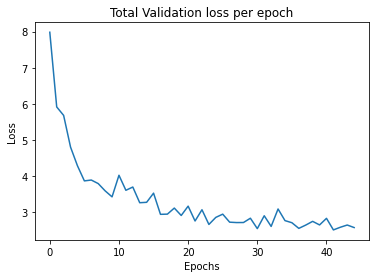

In [ ]:
tot_val_losses = model_bh.val_loss_epoch
plt.plot(tot_val_losses[1:])
plt.title("Total Validation loss per epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

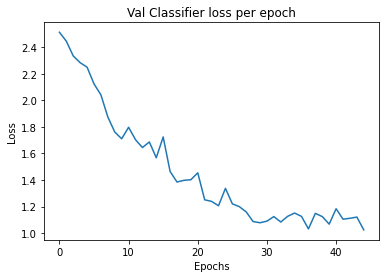

In [ ]:
tot_losses = model_bh.val_class_loss_epoch
plt.plot(tot_losses[1:])
plt.title("Val Classifier loss per epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

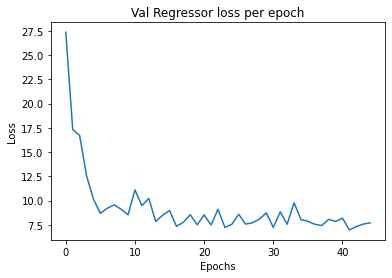

In [ ]:
tot_losses = model_bh.val_reg_loss_epoch
tot_losses = np.array([each_loss.detach().cpu().numpy() for each_loss in tot_losses])
plt.plot(tot_losses[1:])
plt.title("Val Regressor loss per epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [79]:
def visualizer_top_proposals_first(image, boxes, labels):

    boxes = boxes.detach().cpu().numpy()
    image = image.detach().cpu().numpy()
    image = np.clip(image, 0., 255.)

    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot()

    ax.imshow(image)
    for i in range(len(boxes)):
      if labels[i] == 0 :
        rect = patches.Rectangle((boxes[i][0], boxes[i][1],), boxes[i][2] - boxes[i][0], boxes[i][3] - boxes[i][1] , fill=False,color='white')
      elif labels[i] == 1:
        rect = patches.Rectangle((boxes[i][0], boxes[i][1],), boxes[i][2] - boxes[i][0], boxes[i][3] - boxes[i][1] , fill=False,color='blue')
      elif labels[i] == 2:
        rect = patches.Rectangle((boxes[i][0], boxes[i][1],), boxes[i][2] - boxes[i][0], boxes[i][3] - boxes[i][1] , fill=False,color='green')
      elif labels[i] == 3:
        rect = patches.Rectangle((boxes[i][0], boxes[i][1],), boxes[i][2] - boxes[i][0], boxes[i][3] - boxes[i][1] , fill=False,color='red')
      ax.add_patch(rect)

In [29]:
model_bh = BoxHead()
model_bh.load_state_dict(torch.load('model_trained_boxhead_2.pth', map_location=device))
model_bh.eval()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


BoxHead(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps

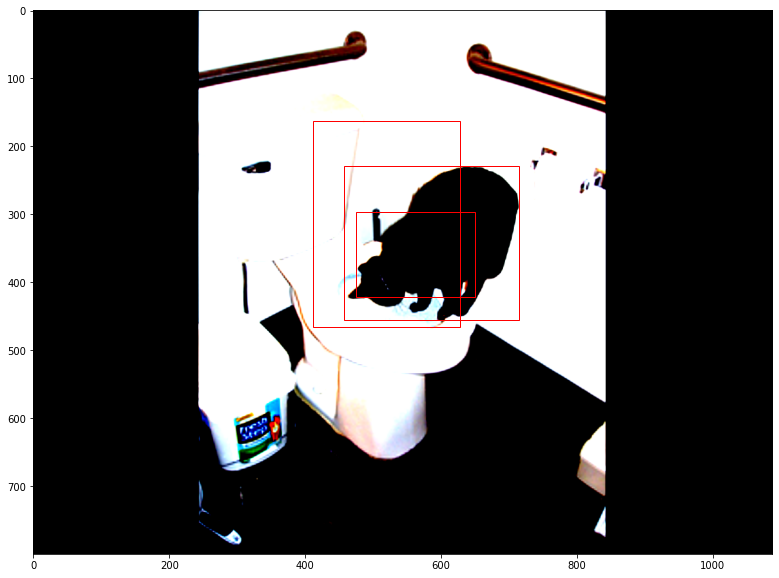

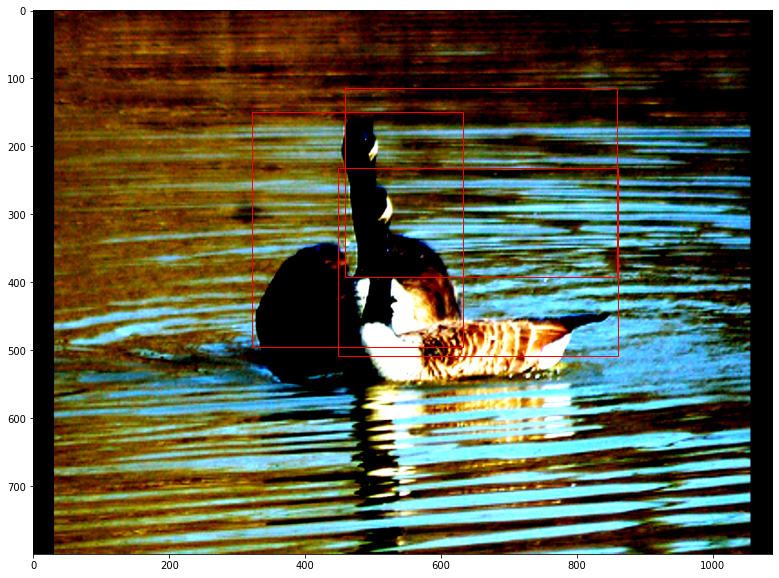

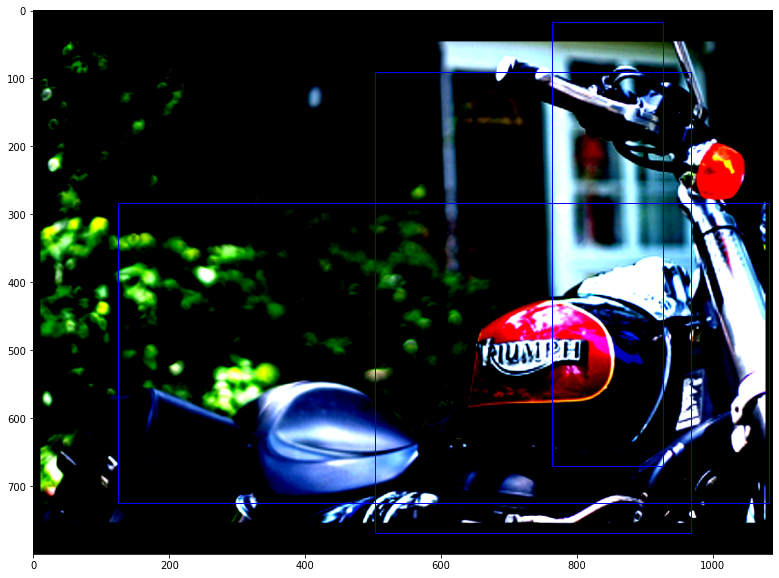

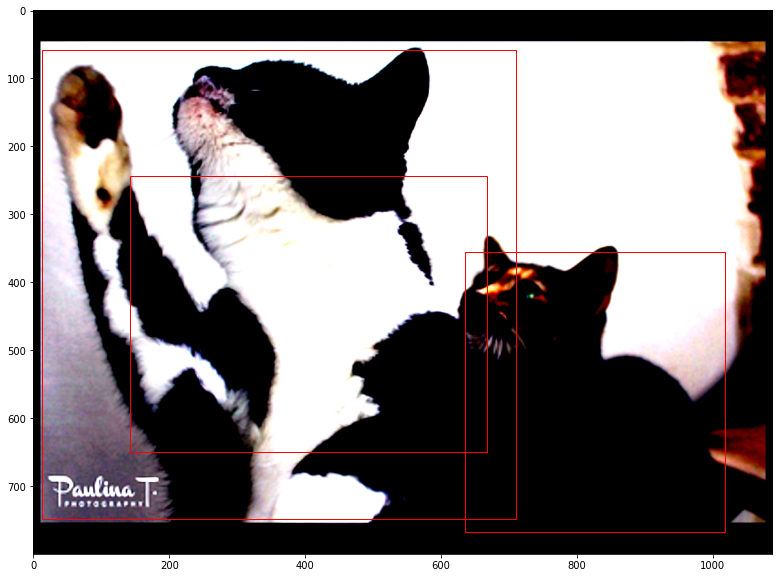

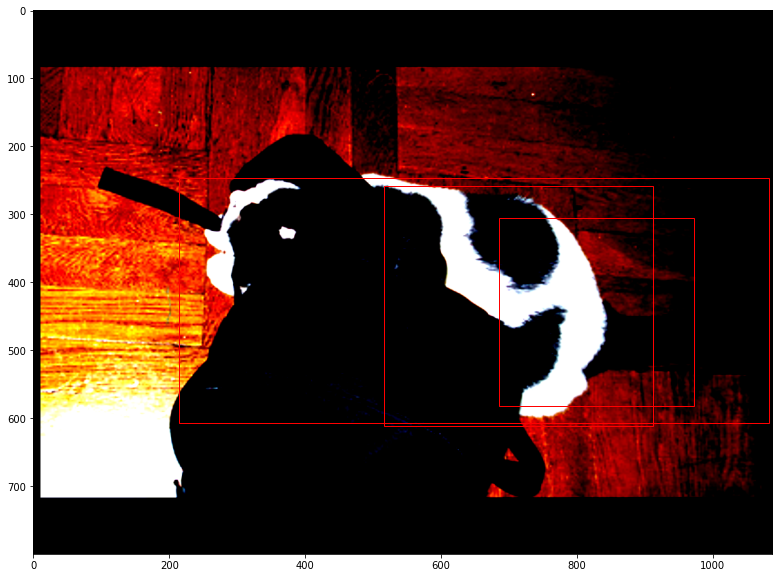

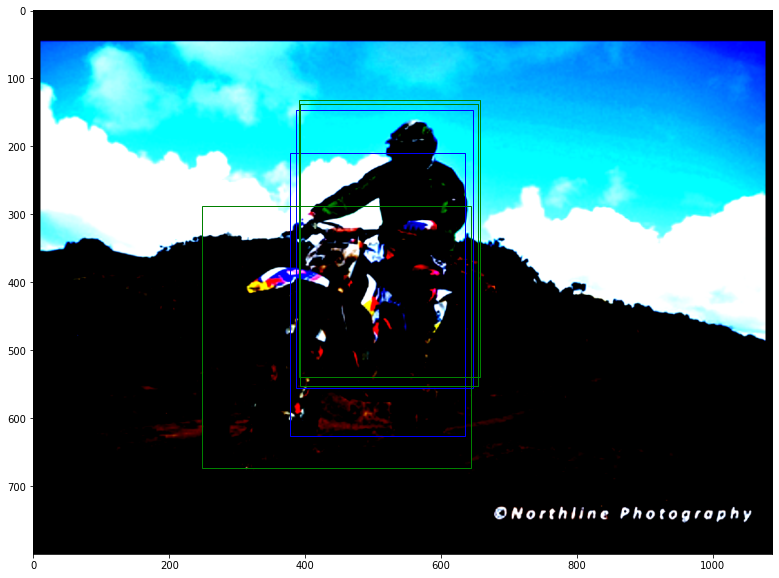

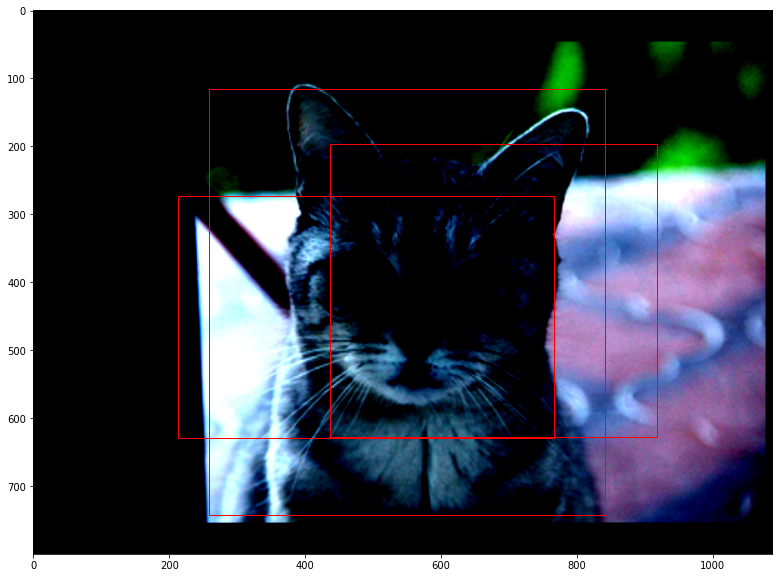

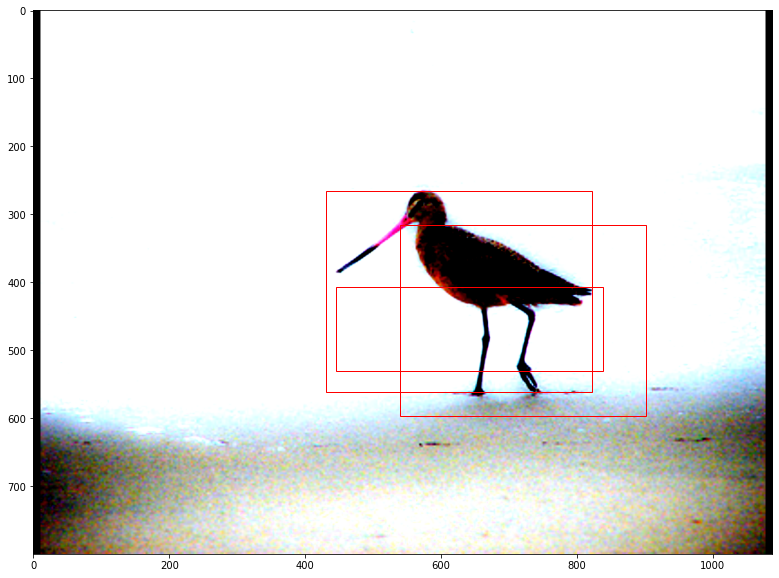

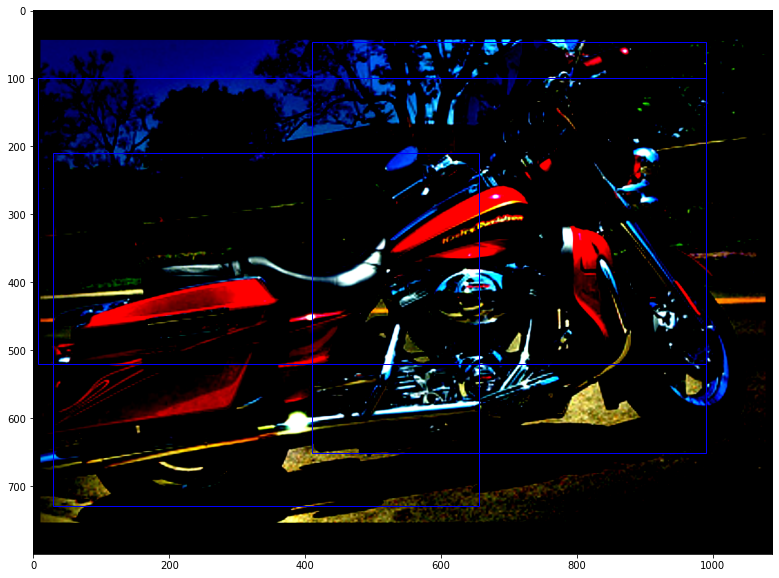

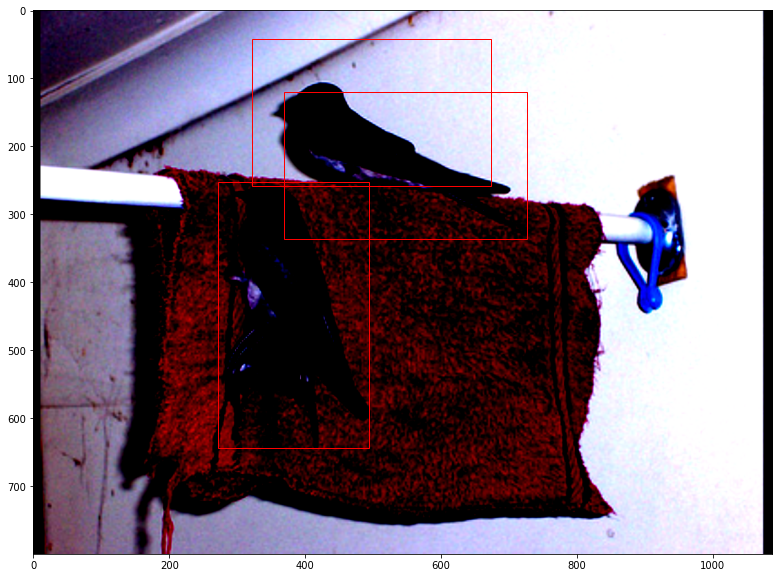

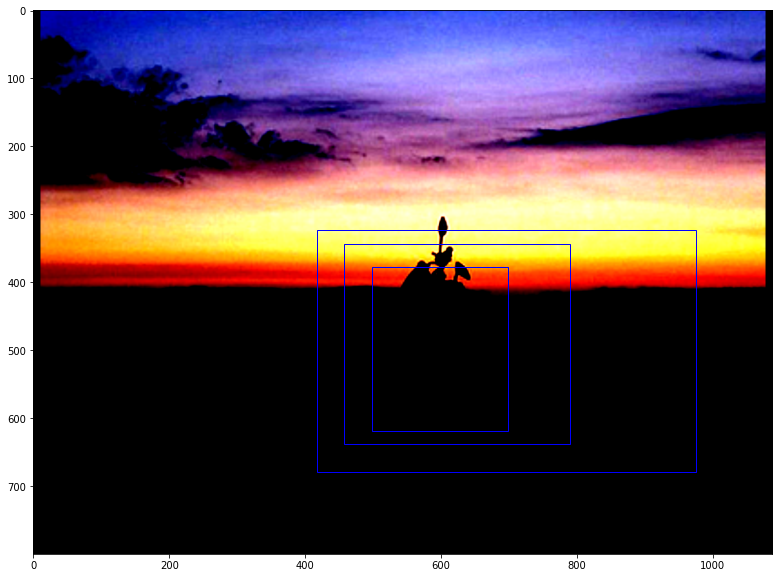

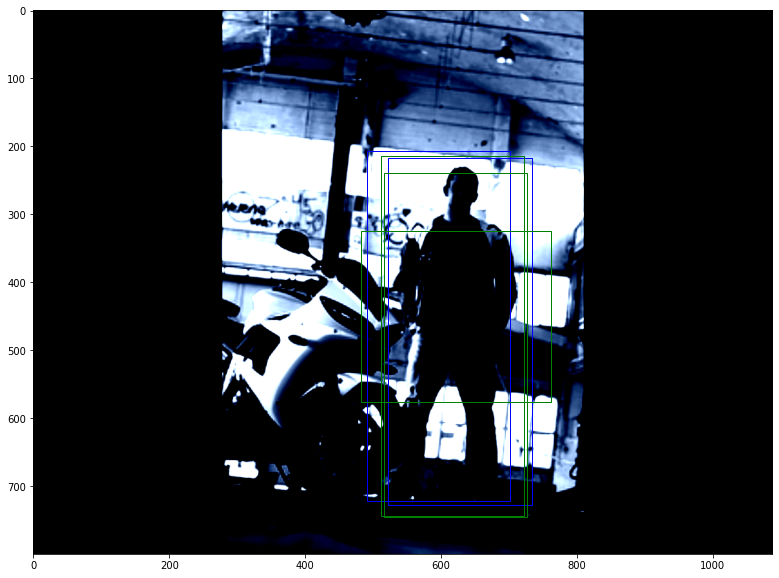

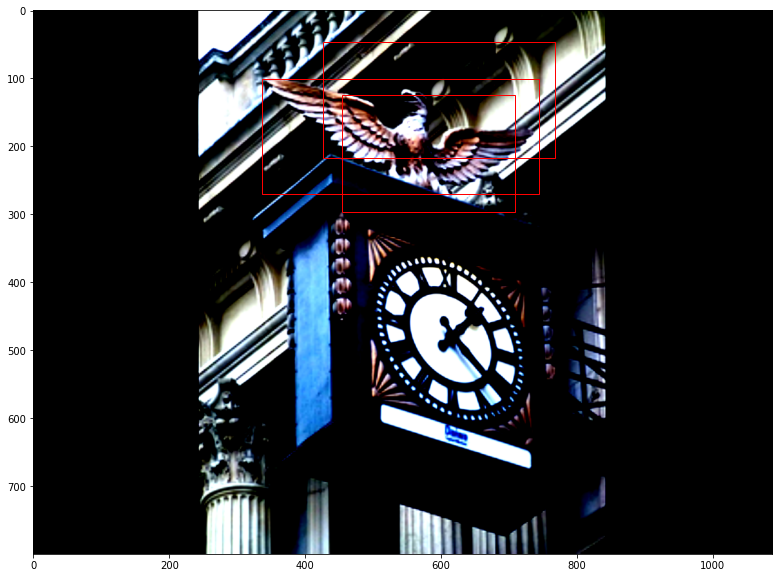

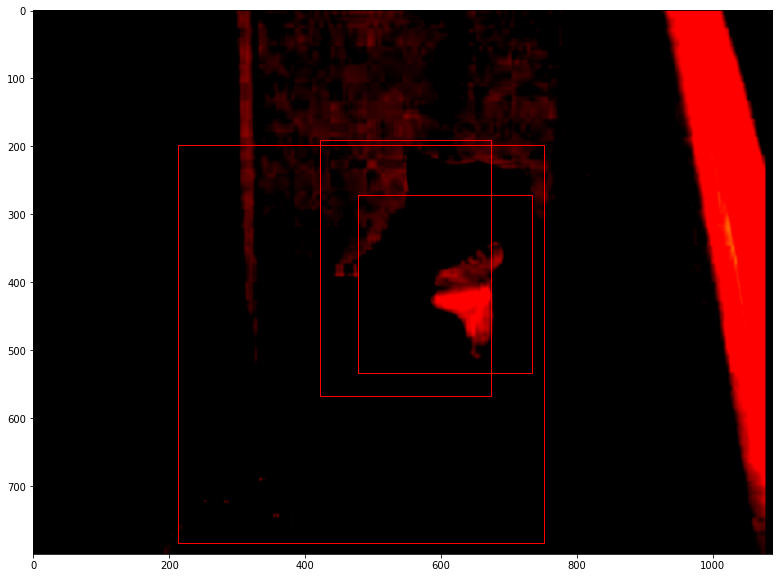

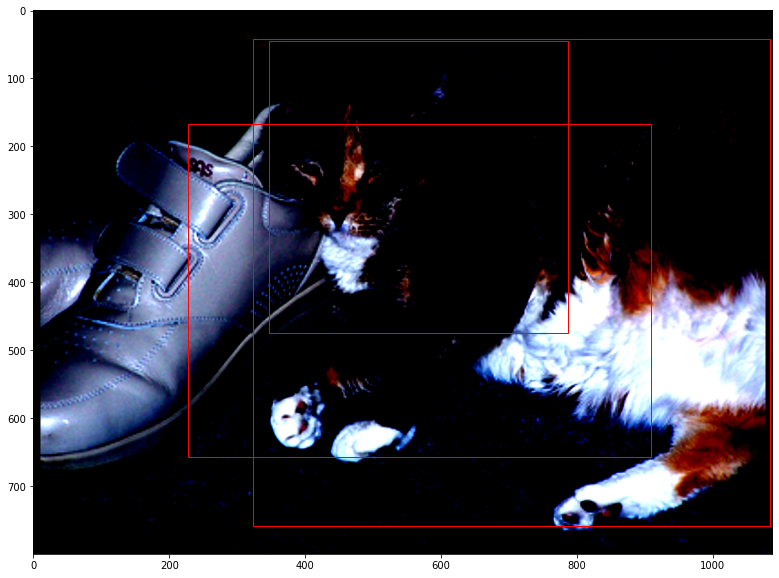

In [82]:
model_bh.to(device)

count = 0
temp_flag = True

for i, each_set in enumerate(train_loader):

  images=each_set['images'].to(device)
  index=each_set['index']
  bounding_boxes=each_set['bboxes']
  gt_label = each_set['labels']

  model_bh.backbone.eval()
  model_bh.rpn.eval()
  with torch.no_grad():
    backout = model_bh.backbone(images)
    im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
    rpnout = model_bh.rpn(im_lis, backout)
  proposals=[proposal[0:model_bh.keep_topK,:] for proposal in rpnout[0]]
  fpn_feat_list = list(backout.values())
  feature_vectors = model_bh.MultiScaleRoiAlign_boxhead(fpn_feat_list,proposals)
      
  class_logits, box_pred = model_bh.forward(feature_vectors, eval=True)

  boxes, scores, labels = model_bh.postprocess_detections(class_logits, box_pred, proposals,conf_thresh=0.5, keep_num_preNMS=500, keep_num_postNMS=3)
  for i in range(4):
    visualizer_top_proposals(images[i].permute(1,2,0), boxes[i], labels[i])

    count += 1
    if count > 10 :
      temp_flag = False
      break


In [92]:
dataset_map = BuildDataset(path)
train_size = 1000
test_size = 200

train_dataset, test_dataset = torch.utils.data.random_split(dataset_map, [train_size, test_size])

batch_size_map = 1
train_build_loader_map = BuildDataLoader(train_dataset, batch_size=batch_size_map, shuffle=False, num_workers=0)
train_loader_map = train_build_loader_map.loader()
test_build_loader_map = BuildDataLoader(test_dataset, batch_size=batch_size_map, shuffle=False, num_workers=0)
test_loader_map = test_build_loader_map.loader()

In [93]:
tp_all = dict({'1':[],'2':[],'3':[]})
scores_all = dict({'1':[],'2':[],'3':[]})
gt_label_all = dict({'1':[],'2':[],'3':[]})

for i, each_set in enumerate(train_loader_map):
  images=each_set['images'].to(device)
  index=each_set['index']
  bounding_boxes=each_set['bboxes']
  gt_label = each_set['labels']

  model_bh.backbone.eval()
  model_bh.rpn.eval()
  with torch.no_grad():
    backout = model_bh.backbone(images)
    im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
    rpnout = model_bh.rpn(im_lis, backout)
  proposals=[proposal[0:model_bh.keep_topK,:] for proposal in rpnout[0]]
  fpn_feat_list = list(backout.values())
  feature_vectors = model_bh.MultiScaleRoiAlign_boxhead(fpn_feat_list,proposals)
      
  class_logits, box_pred = model_bh.forward(feature_vectors, eval=True)
  
  boxes, scores, labels = model_bh.postprocess_detections(class_logits, box_pred, proposals,conf_thresh=0.3, keep_num_preNMS=500, keep_num_postNMS=3)
  gt_label_one = gt_label[0] - 1
  for j in gt_label_one:
    label_idx = j.detach().cpu().item() + 1
    gt_label_all[str(label_idx)].append(label_idx)

  iou_all = ops.box_iou(boxes[0], bounding_boxes[0])

  for j in range(labels[0].shape[0]):
    one_pred_iou = iou_all[j]
    clas_check = gt_label_one.detach().cpu() == labels[0][j]
    pred_ious_clas = one_pred_iou[clas_check]

    check = pred_ious_clas > 0.5
    idx = labels[0][j].detach().cpu().item() + 1
    if check.sum() == 1:
      tp_all[str(idx)].append(1)
      scores_all[str(idx)].append(scores[0][j].detach().cpu().item())
    else:
      tp_all[str(idx)].append(0)
      scores_all[str(idx)].append(scores[0][j].detach().cpu().item())


# BoxHead MAP

In [160]:
map_val_1, rec1, prec1 = prec_rec(scores_all['1'], gt_label_all['1'],tp_all['1'])
map_val_2, rec2, prec2 = prec_rec(scores_all['2'], gt_label_all['2'],tp_all['2'])
map_val_3, rec3, prec3 = prec_rec(scores_all['3'], gt_label_all['3'],tp_all['3'])

print("MAP 1: ", map_val_1)
print("MAP 2: ", map_val_2)
print("MAP 3: ", map_val_3)

print("Average MAP : ", (map_val_1+map_val_2+map_val_3)/3)

MAP 1:  0.3744678051821257
MAP 2:  0.4973440094160174
MAP 3:  0.6372658912569341
Average MAP :  0.5030259019516924


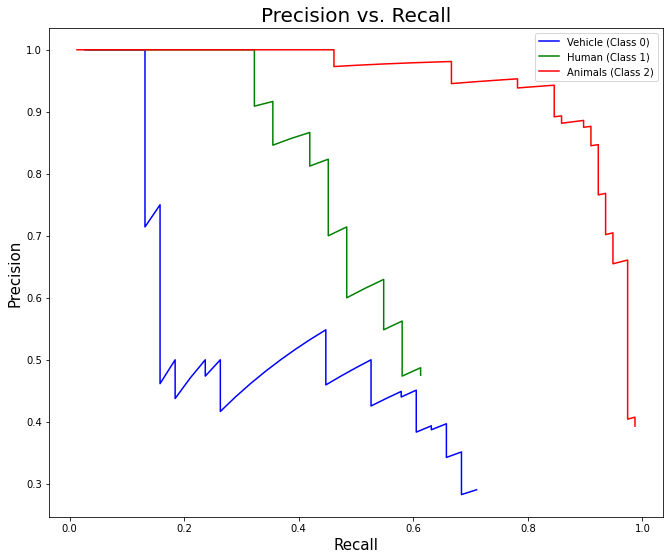

In [119]:
fig = plt.figure(figsize =(11, 9))
plt.title("Precision vs. Recall", size=20)
plt.xlabel('Recall', size=15)
plt.ylabel('Precision', size =15)

plt.plot(rec1, prec1, label ="Vehicle (Class 0)", color="blue")
plt.plot(rec2, prec2, label = "Human (Class 1)", color="green")
plt.plot(rec3, prec3, label = "Animals (Class 2)", color="red")
plt.legend(loc="upper right")
plt.show()

# Mask Head

In [136]:
class MaskHead(pl.LightningModule):
    _default_cfg = {
        'classes': 3,
        'P': 7
    }

    def __init__(self, Classes=3,P=14, batch_size = 4):
        super().__init__()


        self.C=Classes
        self.P=P
        self.keep_topK = 100
        self.batch_size = batch_size
        self.image_size = (800,1088)
        self.pretrained_boxhead_path = '/content/drive/MyDrive/CIS 6800/SOLO dataset/model_trained_boxhead_2.pth'
        self.pretrained_fpn_path = '/content/drive/MyDrive/CIS 6800/SOLO dataset/checkpoint680.pth'
        self.model_boxhead = BoxHead()
        self.model_boxhead.load_state_dict(torch.load(self.pretrained_boxhead_path, map_location=device))
        with torch.no_grad():
          self.backbone, self.rpn = pretrained_models_680(self.pretrained_fpn_path)
        self.train_loss_epoch = []


        self.val_loss_epoch = []


        # TODO initialize MaskHead
        self.mask_head = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding='same'),
            nn.ReLU(True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding='same'),
            nn.ReLU(True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding='same'),
            nn.ReLU(True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding='same'),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=256, out_channels=3, kernel_size=1, padding="same"),
            nn.Sigmoid()
        )
        
    def preprocess_ground_truth_creation(self, proposals, class_logits, box_regression, gt_labels,bbox ,masks , IOU_thresh=0.5, keep_num_preNMS=1000, keep_num_postNMS=10):
        # This function does the pre-prossesing of the proposals created by the Box Head (during the training of the Mask Head)
        # and create the ground truth for the Mask Head
        #
        # Input:
        #       class_logits: (total_proposals,(C+1))
        #       box_regression: (total_proposal,4*C)           ([t_x,t_y,t_w,t_h] format)
        #       proposals: list:len(bz)(per_image_proposals,4) (the proposals are produced from RPN [x1,y1,x2,y2] format)
        #       conf_thresh: scalar
        #       keep_num_preNMS: scalar (number of boxes to keep pre NMS)
        #       keep_num_postNMS: scalar (number of boxes to keep post NMS)
        # Output:
        #       boxes: list:len(bz){(post_NMS_boxes_per_image,4)} ([x1,y1,x2,y2] format)
        #       scores: list:len(bz){(post_NMS_boxes_per_image)}   ( the score for the top class for the regressed box)
        #       labels: list:len(bz){(post_NMS_boxes_per_image)}  (top category of each regressed box)
        #       gt_masks: list:len(bz){(post_NMS_boxes_per_image,C,2*P,2*P)}
        num_proposals = proposals[0].shape[0]
        boxes = []
        scores = []
        labels = []
        gt_masks = []
        for i, each_proposal in enumerate(proposals):
            
            each_proposal = each_proposal.to(device)
            box_regression = box_regression.to(device)
            class_logits = class_logits.to(device)
            # gt_labels[i] = gt_labels[i] - 1
            one_image_boxes = box_regression[i*num_proposals:(i+1)*num_proposals]          # Shape (num_proposals, 12)
            one_image_logits = class_logits[i*num_proposals:(i+1)*num_proposals]           # Shape (num_proposals, 4)
            one_image_scores, one_image_label = torch.max(one_image_logits, dim=1)
            one_image_label = one_image_label.clone().int() - 1
            non_bg_label_idx = torch.where(one_image_label >= 0)[0]

            if len(non_bg_label_idx) != 0: 
                class_labels = one_image_label[non_bg_label_idx]
                all_class_boxes = one_image_boxes[non_bg_label_idx]
                class_boxes =  torch.stack([all_class_boxes[i, x*4:(x+1)*4] for i, x in enumerate(class_labels)])      # Shape(filtered_labels, 4) ([t_x,t_y,t_w,t_h])
                decoded_boxes = output_decoding_postprocess(class_boxes, each_proposal[non_bg_label_idx])                          # (x1,y1,x2,y2)
                
                valid_boxes_idx = torch.where((decoded_boxes[:,0] >= 0) & (decoded_boxes[:,2] < 1088) & (decoded_boxes[:,1] > 0) & (decoded_boxes[:,3] < 800))
                valid_boxes = decoded_boxes[valid_boxes_idx]
                valid_clases = one_image_label[non_bg_label_idx][valid_boxes_idx]
                valid_scores = one_image_scores[non_bg_label_idx][valid_boxes_idx]
                sorted_scores_pre_nms, sorted_idx = torch.sort(valid_scores, descending=True)
                sorted_clases_pre_nms = valid_clases[sorted_idx]
                sorted_boxes_pre_nms = valid_boxes[sorted_idx]

                iou_check = ops.box_iou(sorted_boxes_pre_nms.to(device), bbox[i].to(device))
                iou_idx = (iou_check > 0.5).nonzero()
                above_thres_idx = iou_idx[:,0]
                above_thres_gt = iou_idx[:,1]


                masks_gt_all = masks[i][above_thres_gt.cpu()]
                                
                sorted_boxes_pre_nms = sorted_boxes_pre_nms[above_thres_idx.cpu()]
                sorted_clases_pre_nms = sorted_clases_pre_nms[above_thres_idx.cpu()]
                sorted_scores_pre_nms = sorted_scores_pre_nms[above_thres_idx.cpu()]

                if len(sorted_clases_pre_nms) > keep_num_preNMS:
                    clases_pre_nms = sorted_clases_pre_nms[:keep_num_preNMS]
                    boxes_pre_nms = sorted_boxes_pre_nms[:keep_num_preNMS]
                    scores_pre_nms = sorted_scores_pre_nms[:keep_num_preNMS]
                    masks_pre_nms = masks_gt_all[:keep_num_preNMS]
                else:
                    clases_pre_nms = sorted_clases_pre_nms
                    boxes_pre_nms = sorted_boxes_pre_nms
                    scores_pre_nms = sorted_scores_pre_nms
                    masks_pre_nms = masks_gt_all

                clases_post_nms, scores_post_nms, boxes_post_nms, masks_post_nms = self.nms_preprocess_gt(clases_pre_nms, boxes_pre_nms, scores_pre_nms, masks_pre_nms, IOU_thres=IOU_thresh, keep_num_postNMS=keep_num_postNMS)

                gt_mask_one = torch.zeros(clases_post_nms.shape[0],self.image_size[0], self.image_size[1]).to(device)

                for j in range(clases_post_nms.shape[0]):
                    gt_mask_one[j,boxes_post_nms[j,1].int():boxes_post_nms[j,3].int(),boxes_post_nms[j,0].int():boxes_post_nms[j,2].int()] = 1
                gt_mask_one = gt_mask_one * masks_post_nms
                gt_mask_one = F.interpolate(gt_mask_one.unsqueeze(0), size=(2*self.P,2*self.P),mode='nearest').squeeze(0)
            
            gt_masks.append(gt_mask_one)
            boxes.append(boxes_post_nms)
            scores.append(scores_post_nms)
            labels.append(clases_post_nms)

        return boxes, scores, labels, gt_masks



    def MultiScaleRoiAlign_maskhead(self, fpn_feat_list,proposals):
        #####################################
        # This function for each proposal finds the appropriate feature map to sample and using RoIAlign it samples
        # a (256,P,P) feature map. This feature map is then flattened into a (256*P*P) vector
        # Input:
        #      fpn_feat_list: list:len(FPN){(bz,256,H_feat,W_feat)}
        #      proposals: list:len(bz){(per_image_proposals,4)} ([x1,y1,x2,y2] format)
        #      P: scalar
        # Output:
        #      feature_vectors: len(bz) (total_proposals, 256, 2*P, 2*P)  (make sure the ordering of the proposals are the same as the ground truth creation)
        # Here you can use torchvision.ops.RoIAlign check the docs
        #####################################
        roi_alls = []
        for i in range(len(proposals)):
            each_proposal= conv_box_to_xywh(proposals[i])
            k = (torch.log2(torch.sqrt(each_proposal[:,2]*each_proposal[:,3])/224.) + 4).int()
            k = torch.clamp(k, min=2., max=5.).int()
            each_proposal = conv_box_to_corners(each_proposal)

            scaling_vals = torch.pow(2,k).reshape(-1,1)*torch.ones_like(each_proposal)
            scaled_proposals = each_proposal / scaling_vals

            fpn_list_each_proposal = [fpn_feat_list[j][i].unsqueeze(0) for j in range(5)]
            roi_vals = torch.stack([torchvision.ops.roi_align(fpn_list_each_proposal[k[n]-2], [scaled_proposals[n].view(1,4)], (self.P,self.P)).squeeze(0) for n in range(k.shape[0])], dim=0)
            roi_alls.append(roi_vals)

        return roi_alls

    # general function that takes the input list of tensors and concatenates them along the first tensor dimension
    # Input:
    #      input_list: list:len(bz){(dim1,?)}
    # Output:
    #      output_tensor: (sum_of_dim1,?)
    def flatten_inputs(self,input_list):
        output_tensor = torch.cat(input_list, dim=0)
        return output_tensor

    def compute_loss(self,mask_output,labels,gt_masks):
        # Compute the total loss of the Mask Head
        # Input:
        #      mask_output: (total_boxes,C,2*P,2*P)
        #      labels: len(bz)(total_boxes)
        #      gt_masks: len(bz) (total_boxes,2*P,2*P)
        # Output:
        #      mask_loss
        flattened_gt_masks = self.flatten_inputs(gt_masks)
        flattened_labels = self.flatten_inputs(labels)

        mask_target = []
        for i in range(len(flattened_labels)):
            one_mask_output = mask_output[i]
            mask_target.append(one_mask_output[flattened_labels[i].item()])
        mask_target = torch.stack(mask_target)
        
        criterion = nn.BCELoss()

        mask_loss = criterion(mask_target, flattened_gt_masks)

        return mask_loss.mean()


    def forward(self,  feature_boxes):
        # Forward the pooled feature map Mask Head
        # Input:
        #        features: (total_boxes, 256,P,P)
        # Outputs:
        #        mask_outputs: (total_boxes,C,2*P,2*P)

        mask_outputs = self.mask_head(feature_boxes)

        return mask_outputs

    def nms_preprocess_gt(self,clases,boxes,scores, masks, IOU_thres=0.5, keep_num_postNMS=10):
        # Input:
        #       clases: (num_preNMS, )
        #       boxes:  (num_preNMS, 4)
        #       scores: (num_preNMS,)
        # Output:
        #       boxes:  (post_NMS_boxes_per_image,4) ([x1,y1,x2,y2] format)
        #       scores: (post_NMS_boxes_per_image)   ( the score for the top class for the regressed box)
        #       labels: (post_NMS_boxes_per_image)  (top category of each regressed box)
        ###########################################################
        boxes = boxes.to(device)
        clases = clases.to(device)
        scores = scores.to(device)
        masks = masks.to(device)
        scores_all = [[],[],[]]
        boxes_all = [[],[],[]]
        clas_all = [[],[],[]]
        masks_all = [[],[],[]]

        for i in range(3):
            each_label_idx = torch.where(clases == i)[0]
            if len(each_label_idx) == 0:
              continue
            each_clas_boxes = boxes[each_label_idx]
            each_clas_score = scores[each_label_idx]
            each_clas_mask = masks[each_label_idx]


            start_x_torched = each_clas_boxes[:, 0]
            start_y_torched = each_clas_boxes[:, 1]
            end_x_torched   = each_clas_boxes[:, 2]
            end_y_torched   = each_clas_boxes[:, 3]

            areas_torched = (end_x_torched - start_x_torched + 1) * (end_y_torched - start_y_torched + 1)

            order_torched = torch.argsort(each_clas_score)

            while len(order_torched) > 0:
                # The index of largest confidence score
                index = order_torched[-1]
                
                # Pick the bounding box with largest confidence score
                boxes_all[i].append(each_clas_boxes[index].detach())
                scores_all[i].append(each_clas_score[index].detach())
                masks_all[i].append(each_clas_mask[index].detach())

                if len(boxes_all[i]) == keep_num_postNMS:
                    break

                # Compute ordinates of intersection-over-union(IOU)
                x1 = torch.maximum(start_x_torched[index], start_x_torched[order_torched[:-1]]).to(device)
                x2 = torch.minimum(end_x_torched[index], end_x_torched[order_torched[:-1]]).to(device)
                y1 = torch.maximum(start_y_torched[index], start_y_torched[order_torched[:-1]]).to(device)
                y2 = torch.minimum(end_y_torched[index], end_y_torched[order_torched[:-1]]).to(device)

                # Compute areas of intersection-over-union
                w = torch.maximum(torch.tensor([0]).to(device), x2 - x1 + 1)
                h = torch.maximum(torch.tensor([0]).to(device), y2 - y1 + 1)
                intersection = w * h

                # Compute the ratio between intersection and union
                ratio = intersection / (areas_torched[index] + areas_torched[order_torched[:-1]] - intersection)
                left = torch.where(ratio < IOU_thres)[0]
                order_torched = order_torched[left]
            clas_all[i] = [i]*len(scores_all[i])
        
        fin_masks = torch.cat([torch.stack(one_mask) for one_mask in masks_all if len(one_mask)!=0]).reshape(-1,800,1088)
        fin_scores = torch.cat([torch.tensor(one_score).reshape(-1,1) for one_score in scores_all if len(one_score)!=0],dim=0).reshape(-1,1)
        fin_boxes = torch.cat([torch.stack(one_box) for one_box in boxes_all if len(one_box)!=0]).reshape(-1,4)
        fin_clas = torch.cat([torch.tensor(one_clas) for one_clas in clas_all if len(one_clas)!=0]).reshape(-1,1)
        return fin_clas, fin_scores, fin_boxes, fin_masks


    def training_step(self, batch, batch_idx):
        images=batch['images'].to(device)
        index=batch['index']
        bounding_boxes=batch['bboxes']
        gt_label = batch['labels']
        masks = batch['masks']

        model_bh.eval()
        self.backbone.eval()
        self.rpn.eval()
        with torch.no_grad():
          backout = self.backbone(images)
          im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
          rpnout = self.rpn(im_lis, backout)

        proposals=[proposal[0:self.keep_topK,:] for proposal in rpnout[0]]
        fpn_feat_list = list(backout.values())
        feature_vectors = self.model_boxhead.MultiScaleRoiAlign_boxhead(fpn_feat_list,proposals)
        with torch.no_grad():
          class_logits, box_pred = self.model_boxhead.forward(feature_vectors, eval=True)

        boxes, scores, labels, gt_masks = self.preprocess_ground_truth_creation(proposals, class_logits, box_pred, gt_label,bounding_boxes ,masks , IOU_thresh=0.5, keep_num_preNMS=1000, keep_num_postNMS=3)

        mask_feature_vectors = self.MultiScaleRoiAlign_maskhead(fpn_feat_list,boxes)
        mask_feature_vectors_flattened = self.flatten_inputs(mask_feature_vectors)

        mask_preds = self.forward(mask_feature_vectors_flattened)

        loss = self.compute_loss(mask_preds,labels,gt_masks)
    
        del masks, bounding_boxes, index, gt_label
        del boxes, scores, labels, gt_masks
        torch.cuda.empty_cache()

        self.log("train_loss", loss, prog_bar=True, on_epoch=True)

        return {"loss":loss}

    def training_epoch_end(self, training_step_outputs):
        avg_train_loss = 0

        for i in range(len(training_step_outputs)):
            avg_train_loss += training_step_outputs[i]["loss"].detach().cpu().item()

        self.train_loss_epoch.append(avg_train_loss)



    def validation_step(self, batch, batch_idx):
        images=batch['images']
        index=batch['index']
        bounding_boxes=batch['bboxes']
        gt_label = batch['labels']
        masks = batch['masks']

        self.model_boxhead.eval()
        self.backbone.eval()
        self.rpn.eval()
        with torch.no_grad():
          backout = self.backbone(images)
          im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
          rpnout = self.rpn(im_lis, backout)

        proposals=[proposal[0:self.keep_topK,:] for proposal in rpnout[0]]
        fpn_feat_list = list(backout.values())
        feature_vectors = self.model_boxhead.MultiScaleRoiAlign_boxhead(fpn_feat_list,proposals)
        with torch.no_grad():
          class_logits, box_pred = self.model_boxhead.forward(feature_vectors, eval=True)
        boxes, scores, labels, gt_masks = self.preprocess_ground_truth_creation(proposals, class_logits, box_pred, gt_label,bounding_boxes ,masks , IOU_thresh=0.5, keep_num_preNMS=1000, keep_num_postNMS=3)
        mask_feature_vectors = self.MultiScaleRoiAlign_maskhead(fpn_feat_list,boxes)
        mask_feature_vectors_flattened = self.flatten_inputs(mask_feature_vectors)

        mask_preds = self.forward(mask_feature_vectors_flattened)

        val_loss = self.compute_loss(mask_preds,labels,gt_masks)

        del masks, bounding_boxes, index, gt_label
        del boxes, scores, labels, gt_masks
        torch.cuda.empty_cache()

        self.log("val_loss", val_loss)
        return {"loss":val_loss}

    def validation_epoch_end(self, outputs):
        avg_train_loss = 0

        for i in range(len(outputs)):
            avg_train_loss += outputs[i]["loss"].detach().cpu().item()
    
        self.val_loss_epoch.append(avg_train_loss)

    def configure_optimizers(self):

        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[22,28,35], gamma=0.1)

        return optimizer 

    def postprocess_mask(self, masks_outputs, labels):
        # This function does the post processing for the result of the Mask Head for a batch of images. It project the predicted mask
        # back to the original image size
        # Use the regressed boxes to distinguish between the images
        # Input:
        #       masks_outputs: (total_boxes,C,2*P,2*P)
        #       labels: list:len(bz){(post_NMS_boxes_per_image)}  (top category of each regressed box)
        # Output:
        #       projected_masks: list:len(bz){(post_NMS_boxes_per_image,image_size[0],image_size[1]
        projected_masks = []
        count = 0
        for i, each_label in enumerate(labels):
            each_masks = masks_outputs[count:(count+each_label.shape[0])]
            fin_each_masks = torch.stack([each_masks[l,one_each_label.item()] for l,one_each_label in enumerate(each_label)])
            count += each_label.shape[0]
            one_projected_mask = F.interpolate(fin_each_masks.unsqueeze(0), size=(800,1088), mode="bilinear").squeeze(0)
            one_projected_mask[one_projected_mask >= 0.5] = 1
            one_projected_mask[one_projected_mask < 0.5] = 0
            projected_masks.append(one_projected_mask)     

        return projected_masks




In [139]:
from pytorch_lightning.callbacks import ModelCheckpoint
val_checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="./training_data_new_model_1",
    filename="val_loss{epoch:02d}-{val_loss:.2f}",
    save_top_k=3,
    mode="min",
)
train_checkpoint_callback = ModelCheckpoint(
    monitor="train_loss",
    dirpath="./training_data_new_model_1",
    filename="train_loss{epoch:02d}-{train_loss:.2f}",
    save_top_k=3,
    mode="min",
)

model = MaskHead()

epochs = 45

tb_logger = pl_loggers.TensorBoardLogger("tb_logs", name="mask_rcnn")
# trainer = pl.Trainer(accelerator='cpu', devices=1, max_epochs=epochs, logger=tb_logger, callbacks=[val_checkpoint_callback,train_checkpoint_callback])
trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs=epochs, logger=tb_logger, callbacks=[val_checkpoint_callback,train_checkpoint_callback])
# trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs=epochs, logger=tb_logger, resume_from_checkpoint = "/content/training_data_new_model_1/train_lossepoch=27-train_loss=0.25.ckpt", callbacks=[val_checkpoint_callback,train_checkpoint_callback])

trainer.fit(model, train_loader, test_loader)

PATH = 'model_trained_maskhead.pth'
torch.save(model.state_dict(), PATH)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                  | Params
--------------------------------------------------------
0 | model_boxhead | BoxHead               | 43.7 M
1 | backbone      | BackboneWithFPN       | 26.8 M
2 | rpn           | RegionProposalNetwork | 593 K 
3 | mask_head     | Sequential            | 3.0 M 
--------------------------------------------------------
73.6 M    Trainable params
444 K     Non-trainable params
74.0 M    Total params
296.072   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=45` reached.


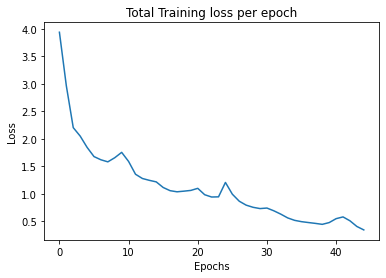

In [142]:
tot_train_losses = model.train_loss_epoch
plt.plot(tot_train_losses)
plt.title("Total Training loss per epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

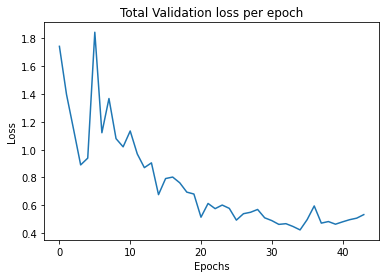

In [145]:
tot_val_losses = model.val_loss_epoch
plt.plot(tot_val_losses)
plt.title("Total Validation loss per epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [150]:
model_mh = MaskHead()
model_mh.load_state_dict(torch.load('model_trained_maskhead.pth', map_location=device))
model_mh.eval()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MaskHead(
  (model_boxhead): BoxHead(
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=1e-05)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64, eps=1e-05)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d(64, eps=1e-05)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): FrozenBatchNorm2d(256, eps=1e-05)
            (relu): ReLU(inplace=True)
            (downsample): Sequential(
              (0): Conv2d(64, 256, kernel_size=(1, 1), stride=

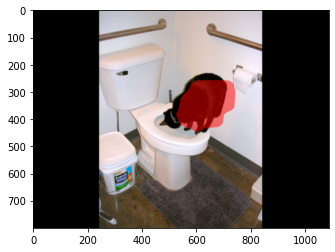

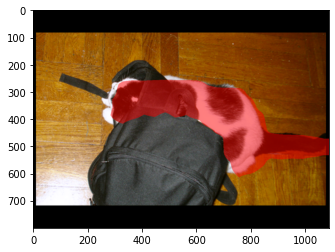

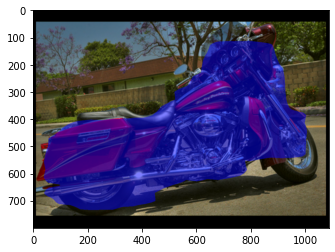

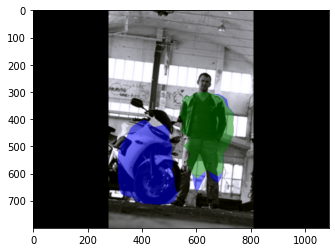

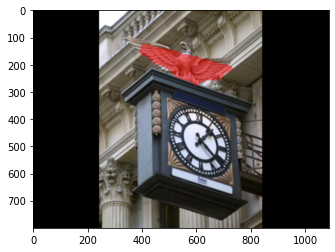

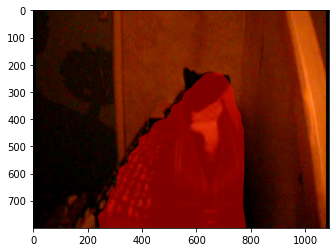

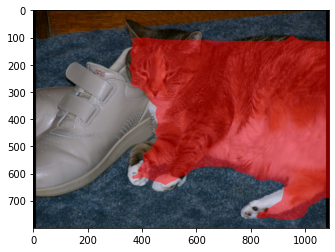

In [151]:
model_mh.to(device)

counter = 0
temp_flag = True

for i, each_set in enumerate(train_loader):
  images=each_set['images'].to(device)
  index=each_set['index']
  bounding_boxes=each_set['bboxes']
  gt_label = each_set['labels']
  masks = each_set['masks']

  model_bh.eval()
  model_mh.backbone.eval()
  model_mh.rpn.eval()
  with torch.no_grad():
    backout = model_mh.backbone(images)
    im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
    rpnout = model_mh.rpn(im_lis, backout)

  proposals=[proposal[0:model_mh.keep_topK,:] for proposal in rpnout[0]]
  fpn_feat_list = list(backout.values())
  feature_vectors = model_mh.model_boxhead.MultiScaleRoiAlign_boxhead(fpn_feat_list,proposals)
  with torch.no_grad():
    class_logits, box_pred = model_mh.model_boxhead.forward(feature_vectors, eval=True)

  boxes, scores, labels, gt_masks = model_mh.preprocess_ground_truth_creation(proposals, class_logits, box_pred, gt_label,bounding_boxes ,masks , IOU_thresh=0.5, keep_num_preNMS=1000, keep_num_postNMS=3)

  mask_feature_vectors = model_mh.MultiScaleRoiAlign_maskhead(fpn_feat_list,boxes)
  mask_feature_vectors_flattened = model_mh.flatten_inputs(mask_feature_vectors)

  mask_preds = model_mh.forward(mask_feature_vectors_flattened)

  output_masks_final = model_mh.postprocess_mask(mask_preds, labels)

  for k in range(len(output_masks_final)):
  
    visualize_raw_processor(images[k], output_masks_final[k], labels[k])

    count += 1
    if count > 10 :
      temp_flag = False
      break

